# Fairness Exercises

Install/Import (Notebook's code)

In [9]:
#@title Install dependencies

!pip install aif360;
!pip install fairlearn;

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [10]:
#@title Import statements

# import statements
# create simple model using logistic regression
# evaluate model on those metrics

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, recall_score, precision_score

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.inprocessing import MetaFairClassifier

from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_german
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, average_odds_difference
from aif360.sklearn.metrics import generalized_fnr, difference, statistical_parity_difference, equal_opportunity_difference, generalized_entropy_error

from IPython.display import Markdown, display

In [11]:
#@title Confusion matrix and Visualisation plots

# Function for visualising the confusion matrix and other statistics
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf_matrix, model):
  group_names = ["True Negative","False Positive","False Negative","True Positive"]
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  group_labels = ["{}\n".format(value) for value in group_names]
  group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

  box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0],cf_matrix.shape[1])


  # add more statistics
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
  f1_score  = 2*precision*recall / (precision + recall)
  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
      accuracy,precision,recall,f1_score)


  categories=["Bad creadit", "Good credit"]
  sns.heatmap(cf_matrix,annot=box_labels,fmt="",cmap='Purples',xticklabels=categories,yticklabels=categories)

  plt.ylabel('True label')
  plt.xlabel('Predicted label' + stats_text)
  plt.title(f"Confusion matrix and statistics for the {model} model");

def metrics_per_group(y_test, y_pred):
	# y true per group
	y_test_male = y_test.loc[y_test.index.get_level_values(1) == 1]
	y_test_female = y_test.loc[y_test.index.get_level_values(1) == 0]

	# y_pred per group
	y_pred_male = y_pred[y_test.index.get_level_values(1) == 1]
	y_pred_female = y_pred[y_test.index.get_level_values(1) == 0]

	# metrics
	scores = []
	scores.append(accuracy_score(y_test, y_pred))
	scores.append(recall_score(y_test, y_pred))
	scores.append(precision_score(y_test, y_pred))

	scores.append(accuracy_score(y_test_female, y_pred_female))
	scores.append(recall_score(y_test_female, y_pred_female))
	scores.append(precision_score(y_test_female, y_pred_female))

	scores.append(accuracy_score(y_test_male, y_pred_male))
	scores.append(recall_score(y_test_male, y_pred_male))
	scores.append(precision_score(y_test_male, y_pred_male))

	attribute = ["all"]*3 + ["female"] *3 + ["male"] *3
	metric = ["accuracy", "recall", "precision"] * 3
	  
	# dictionary of lists 
	dict = {'gender': attribute, 'metrics': metric, 'score': scores} 
	    
	df = pd.DataFrame(dict)

	sns.barplot(x = "metrics", y = "score", hue = "gender", data = df, palette = ['#dfcd1a', '#9d0677', '#236c48'])
	plt.title("Performance metrics by groups")
 

def plot_fair_metrics(fair_metrics_mitigated, model): 
  cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'generalized_entropy']
  obj_fairness = [[0,0,1]]

  # row for objectives    
  fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
      
  # row for baseline model
  fair_metrics.loc['Baseline Model'] = [stat_par_diff, eq_opp_diff, gen_entr_error]

  # row for mitigated bias
  fair_metrics.loc[model] = fair_metrics_mitigated


  metrics_len = len(cols)


  fig, ax = plt.subplots(figsize=(20,4), ncols=metrics_len, nrows=1)

  plt.subplots_adjust(
      left    =  0.125, 
      bottom  =  0.1, 
      right   =  0.9, 
      top     =  0.9, 
      wspace  =  .5, 
      hspace  =  1.1
  )

  y_title_margin = 1.2

  plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
  sns.set(style="dark")

  cols = fair_metrics.columns.values
  obj = fair_metrics.loc['objective']
  size_rect = [0.2,0.2,0.2,0.4,0.25]
  rect = [-0.1,-0.1,-0.1,0.8,0]
  bottom = [-1,-1,-1,0,0]
  top = [1,1,1,2,1]
  bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

  for i in range(0,metrics_len):
      plt.subplot(1, metrics_len, i+1)
      ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
      
      for j in range(0,len(fair_metrics)-1):
          a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
          marg = -0.2 if val < 0 else 0.1
          ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

      plt.ylim(bottom[i], top[i])
      plt.setp(ax.patches, linewidth=0)
      ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
      plt.axhline(obj[i], color='black', alpha=0.3)
      plt.title(cols[i])
      ax.set_ylabel('')    
      ax.set_xlabel('')

Load German Credit Dataset

My code and questions (?) -- will read documentation more closely!

In [25]:
#Load German Dataset 
fetch_german()

#map protected attributes to integers (0 or 1) where privileged = 1, unprivileged = 0
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)
#(?) what are names? why is X capitalized and y not?

# set target class to 0/1
y = pd.Series(y.factorize(sort=True)[0], index=y.index)
#(?) what is factorize?

#prep data for algorithm by normalizing input 
#(?) what's this? is this the splitting for training?
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234567)

#(what is one-hoy? one-hot? what's that?)
# one-hoy encode the categorical features
# preproc = pre processing? 
data_preproc = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown='ignore'), X_train.dtypes == 'category'))

X_train = pd.DataFrame(data_preproc.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(data_preproc.transform(X_test), index=X_test.index)

# to save the information for the column names
pd.get_dummies(X).head()
#(?) what's get dummies?
#(?) how to "knit" this? 

Notebook's code

In [32]:
#load German dataset
X, y = fetch_german()
print(f'There are {X.shape[0]} entries and {X.shape[1]} features')
X.head()

There are 1000 entries and 21 features


,,,,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,other_parties,residence_since,...,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,sex,marital_status
,sex,age,foreign_worker,,,,,,,,,,,,,,,,,,,,,
0,male,aged,yes,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,none,4.0,...,67.0,none,own,2.0,skilled,1.0,yes,yes,male,single
1,female,young,yes,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,none,2.0,...,22.0,none,own,1.0,skilled,1.0,none,yes,female,div/dep/mar
2,male,aged,yes,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,none,3.0,...,49.0,none,own,1.0,unskilled resident,2.0,none,yes,male,single
3,male,aged,yes,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,guarantor,4.0,...,45.0,none,for free,1.0,skilled,2.0,none,yes,male,single
4,male,aged,yes,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,none,4.0,...,53.0,none,for free,2.0,skilled,2.0,none,yes,male,single


In [33]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

In [34]:
# set target class to 0/1
y = pd.Series(y.factorize(sort=True)[0], index=y.index)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234567)

# one-hoy encode the categorical features
data_preproc = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown='ignore'), X_train.dtypes == 'category'))

X_train = pd.DataFrame(data_preproc.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(data_preproc.transform(X_test), index=X_test.index)

# to save the information for the column names
pd.get_dummies(X).head()

,,,,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,...,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes,sex_female,sex_male,marital_status_div/dep/mar,marital_status_div/sep,marital_status_mar/wid,marital_status_single
,sex,age,foreign_worker,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,0,1,0,...,0,1,0,1,0,1,0,0,0,1
1,0,0,1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,1,0,0,...,1,0,0,1,1,0,1,0,0,0
2,1,1,1,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
3,1,1,1,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,0,1,0,...,1,0,0,1,0,1,0,0,0,1
4,1,1,1,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


Exploratory Data Analysis

My code

<AxesSubplot:xlabel='credit score', ylabel='count'>

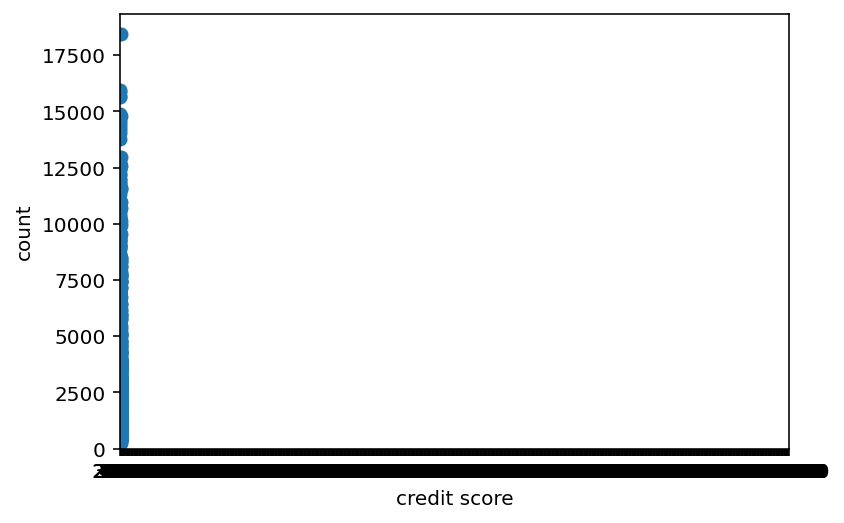

In [41]:
#(?) subpopulations I don't understand what this means

# IDing individuals?-- possibly given that there are many columns about each individual ... maybe no exact ID but a guess?

# errors or noise? make scatterplot?
# https://nickmccullum.com/python-visualization/scatterplot/
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

df_viz = X.copy()
x = df_viz['sex']
y = df_viz['credit_amount']
plt.scatter(x,y)
# is there noise on the female side?
#not sure about redundancies

#let's make the example plot now

df_viz = X.copy()
df_viz['sex'] = X['sex'].replace({1.0: 'Male', 0.0: 'Female'})
df_viz['credit score'] = y.replace({1:'good', 0: 'bad'})
df_viz.index = df_viz.index.droplevel('sex')

purple = '#9d0677'
green = '#30875c'
workshop_palette = [purple, green]

sns.countplot(x='credit score', data=df_viz, palette=workshop_palette)

#should gender be categorized as binary?


Notebook's code

In [19]:
df_viz = X.copy()
df_viz['sex'] = X['sex'].replace({1.0: 'Male', 0.0: 'Female'})
df_viz['credit score'] = y.replace({1:'good', 0: 'bad'})
df_viz.index = df_viz.index.droplevel('sex')

purple = '#9d0677'
green = '#30875c'
workshop_palette = [purple, green]

<AxesSubplot:xlabel='credit score', ylabel='count'>

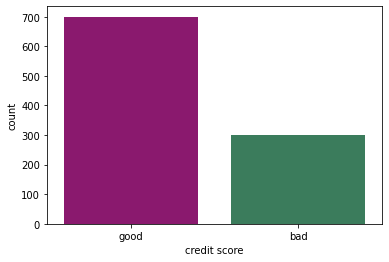

In [20]:
sns.countplot(x='credit score', data=df_viz, palette=workshop_palette)

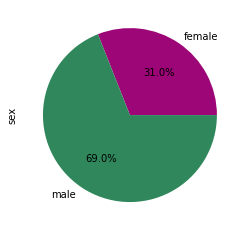

In [21]:
#@title Gender demographics

data = df_viz.groupby('sex')['sex'].count()

data.plot.pie(autopct="%.1f%%", colors=workshop_palette);

# Compas

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
#import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, recall_score, precision_score

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

In [47]:
Data = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-raw.csv")

In [48]:
display(Data)

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60838,65667,79665,72038,Probation,West,James,NaN,Male,African-American,06/21/64,...,3,Medium with Override Consideration,8,Risk of Recidivism,0.16,8,High,New,1,0
60839,65667,79665,72038,Probation,West,James,NaN,Male,African-American,06/21/64,...,3,Medium with Override Consideration,18,Risk of Failure to Appear,35.00,10,High,New,1,0
60840,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,02/06/85,...,1,Low,7,Risk of Violence,-2.75,2,Low,New,1,0
60841,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,02/06/85,...,1,Low,8,Risk of Recidivism,-0.34,5,Medium,New,1,0


In [1]:
print(Data)

NameError: name 'Data' is not defined

In [10]:
#@title Install dependencies

!pip install aif360;
!pip install fairlearn;
##!pip install 'aif360[AdversarialDebiasing]'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
